 ## <font color='brown' face='Time New Roman'>1. Actuarial theoretical formula</font> 

**<font color='green' face='Time New Roman'>Importing packages**

In [183]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [184]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

**<font color='green' face='Time New Roman'>Implementation of basic formulas**

In [185]:
def extract_mortality_table(age):

    # File path of the Excel file
    file_path = "TGF05-TGH05.xls" 
    # Calculating the year of birth based on age
    year_of_birth = 2005 - age
    
    # Load the Excel file using Pandas
    xl = pd.ExcelFile(file_path)

    # Selecting the sheet name based on gender
    sheet_name = 'TGF05' 

    # Load data from the corresponding sheet
    df = xl.parse(sheet_name)

    # Selecting the column corresponding to the year of birth
    column_index = year_of_birth - 1900  # 1900 corresponds to column 2 in the Excel
    mortality_column = df.iloc[:, column_index+1]

    # Convert to a NumPy array
    mortality_table_array = mortality_column.values

    return mortality_table_array
#test
MortalityTable = extract_mortality_table(0)
MortalityTable

array([100000,  99745,  99663,  99626,  99605,  99591,  99580,  99570,
        99562,  99554,  99546,  99538,  99529,  99520,  99510,  99499,
        99487,  99472,  99455,  99435,  99413,  99390,  99366,  99343,
        99320,  99296,  99272,  99248,  99224,  99199,  99174,  99148,
        99121,  99093,  99064,  99034,  99002,  98968,  98932,  98894,
        98853,  98808,  98760,  98706,  98644,  98582,  98513,  98441,
        98363,  98280,  98187,  98088,  97987,  97882,  97774,  97666,
        97556,  97442,  97324,  97205,  97083,  96960,  96836,  96711,
        96585,  96454,  96319,  96180,  96035,  95885,  95729,  95565,
        95394,  95215,  95025,  94824,  94609,  94378,  94128,  93855,
        93554,  93218,  92839,  92407,  91905,  91315,  90611,  89757,
        88711,  87425,  85849,  83940,  81671,  79040,  76056,  72730,
        69078,  65131,  60928,  56517,  51956,  47307,  42638,  38017,
        33513,  29188,  25100,  21298,  17818,  14688,  11920,   9516,
      

In [186]:
def lx(x):
    if x < 0 or x >= len(MortalityTable):
        return None # when 
    return MortalityTable[x+1]

$$ \text{DF}(h,techrate)= \frac{1}{{(1 + techrate)^h}} $$

In [187]:
def techDF(h, techrate):
    return 1 / ((1 + techrate) ** h)

$$ \text{Dx}(x, \text{techrate}) = \frac{1}{{(1 + \text{techrate})^x}} \times \text{lx}(x) \quad \text{where} \quad x \text{ represents age } $$


In [188]:
def Dx(x,techrate):
    return techDF(x,techrate) * lx(x)
#test
Dx(25,0.05)

29315.296751980215

$$ \text{Nx}(x,techrate) = \sum_{i=0}^{121 - x} \left( \frac{1}{{(1 + \text{techrate})^{x + i}}} \times \text{lx}(x + i) \right) $$


In [189]:
def Nx(x,techrate):
    Nx = 0
    for i in range(0, 121 - x):
        Nx+= Dx(x+i,techrate)
    return Nx
#test
Nx(25,0.05)

592584.8289653945

$$ \text{npx}(x, n) = \frac{\text{lx}(x + n)}{\text{lx}(x)} \quad \text{where} \quad n \text{ represents terms }$$ 

In [190]:
def npx(x,n):
    return lx(x + n) / lx(x)
#test
npx(25,10)

0.997280199854944

$$ \text{mprime\_axn}(x, n, \text{techrate}, \text{mprime}) = \sum_{k = \text{mprime} + 1}^{\text{mprime} + n} \text{techDF}(k, \text{techrate}) \times \text{npx}(x, k) $$


In [191]:
def mprime_axn(x, n, techrate, mprime):
    valeur_actuarielle = 0

    for k in range(mprime + 1, mprime + n + 1):
        if x+n+mprime <= 122 :
            # Assuming techDF and npx return single numeric values
            tech_value = techDF(k, techrate)
            npx_value = npx(x, k)

            # Ensure they are numeric values and then perform multiplication
            if isinstance(tech_value, (int, float)) and isinstance(npx_value, (int, float)):
                valeur_actuarielle += tech_value * npx_value
            else:
                # Handle non-numeric outputs here, either by skipping, assigning default values, or raising an error
                pass  # Placeholder; add your logic here
        else : 
            pass
    return valeur_actuarielle
#test
mprime_axn(25,10,0.02,5)

8.112079476091385

$$ \text{nEx}(x, n, \text{techrate}) = \text{npx}(x, n) \times \text{techDF}(n, \text{techrate}) $$


In [192]:
def nEx(x,n, techrate):
    return npx(x, n) * techDF(n, techrate)
#test
nEx(25,10,0.02)

0.8181171164501582

$$ \text{AnnuityFactor}(x,m,techrate) = \sum_{h=0}^{m-1} \text{nEx}(x, h, \text{techrate}) \quad \text{where} \quad m \text{ payments }$$


In [193]:
def annuity_factor (x,m,techrate) :
    Annuityfactor = 0
    for h in range(0,m):
        Annuityfactor+=nEx(x,h,techrate)
    return Annuityfactor
#test
annuity_factor(25,10,0.02)

9.15208389170612

$$ \text{ImmediateLifeAnnuityDue}(x,techrate) = \frac{\text{Nx}(x, \text{techrate})}{\text{Dx}(x, \text{techrate})} $$


In [194]:
def immediate_life_annuity_due(x,techrate):
    immediate_life_annuity_due = Nx(x,techrate)/Dx(x,techrate)
    return(immediate_life_annuity_due)
#test
immediate_life_annuity_due(25,0.05)

20.214184900767414

$$ \text{ImmediateTemporaryLifeAnnuity}(x,n,techrate,deferred) = \frac{\text{Nx}(x + \text{deferred} + 1, \text{techrate}) - \text{Nx}(x + \text{deferred} + n + 1, \text{techrate})}{\text{Dx}(x, \text{techrate})} $$


In [195]:
def immediate_temporary_life_annuity_deferred(x,n,techrate,deferred):
    immediate_temporary_life_annuity = (Nx(x+deferred+1,techrate)-Nx(x+deferred+n+1,techrate))/Dx(x,techrate)
    return(immediate_temporary_life_annuity)
#test
immediate_temporary_life_annuity_deferred(25,10,0.02,3)

8.445394261402846

$$\text{singlePremium}(x,n,\text{techrate}, \text{Amount}, \text{deferred}) = \text{ImmediateTemporaryLifeAnnuity}(x,n,\text{techrate}, \text{deferred}) \times \text{Amount} $$


In [196]:
def singlePremium(x,n,techrate,defrred,amount):
    premium = immediate_temporary_life_annuity_deferred(x,n,techrate,defrred)*amount
    return premium
#test
singlePremium(25,10,0.02,5,1000)

8112.079476091393

$$ \text{annualPremium}(x, n, m, \text{techrate}, \text{amount}, \text{deferred}) = \frac{\text{singlePremium}(x, n, \text{techrate}, \text{deferred}, \text{amount})}{\text{annuityFactor}(x, m, \text{techrate})} $$

In [197]:
def anuualPremium(x,n,m,techrate,amount,deferred):
    return singlePremium(x,n,techrate,deferred,amount)/annuity_factor(x,m,techrate)

#test
new_data = anuualPremium(40,15,20,0.02,1000,5)
print(new_data)
new_data1 = anuualPremium(40,20,15,0.1,2000,2)
print(new_data1)

695.394057670831
1675.576327350932


## <font color='brown' face='Time New Roman'>2. Dataset

**<font color='green' face='Time New Roman'>Generation of the dataset**

In [155]:
# Parameters
deferred = [0, 1, 5, 10, 20, 30, 40]
N_samples = 1000  # Size of the dataset
age_samples = np.random.choice([20, 30, 40, 50, 60], N_samples)  # Samples 1000 ages in [20, 30, 40, 50, 60]
terms_samples = np.random.choice([1, 5, 10, 20, 30, 40, 50, 60], N_samples)  # Samples 1000 terms in [20, 30, 40, 50, 60]
technicals_samples = np.random.choice([0, 0.005, 0.01, 0.015, 0.02, 0.025], N_samples)  # Samples 1000 technical rates
amounts_samples = np.random.choice([50, 100, 200, 400, 800, 1000, 2000], N_samples)  # Samples 1000 amounts
payment_samples = np.random.choice([1, 5, 10, 20, 30, 40], N_samples)  # Samples 1000 premium payments in [20, 30, 40, 50, 60]
deferments_samples = np.random.choice(deferred, N_samples)  # Samples 1000 annuities deferments in [20, 30, 40, 50, 60]
# Creating an empty list that contains annual_premiums and single_premiums
annual_premiums = np.zeros(N_samples)
#single_premiums = np.zeros(N_samples)

for i in range(N_samples):
    age_sample = age_samples[i]
    MortalityTable = extract_mortality_table(age_sample)
    payments_sample = payment_samples[i]
    term_sample = terms_samples[i]
    techrate_sample = technicals_samples[i]
    amount_sample = amounts_samples[i]

    # deferred should be less than payments
    while deferments_samples[i] >= payments_sample:
        deferments_samples[i] = np.random.choice(deferred)
    
    deferred_sample= deferments_samples[i]

    #singlePremium(x,n,techrate,defrred,amount):

    #single_premium=singlePremium(age_sample,term_sample,techrate_sample,deferred_sample,amount_sample)
    #single_premiums[i]+=single_premium
    annual_premium=anuualPremium(age_sample,term_sample,payments_sample,techrate_sample,amount_sample,deferred_sample)
    annual_premiums[i]+=annual_premium

# DataFrame
df = pd.DataFrame({'Age': age_samples, 'Number of payments': payment_samples, 'Annuity deferment': deferments_samples,
                   'Term': terms_samples, 'Technical Rate': technicals_samples, 'Annuity amount': amounts_samples,
                   'Annual_premium': annual_premiums})#'Single_premium' : single_premiums})

**<font color='green' face='Time New Roman'>Displaying the dataset**

In [156]:
df

,Age,Number of payments,Annuity deferment,Term,Technical Rate,Annuity amount,Annual_premium
0,40,10,5,5,0.010,2000,961.983418
1,20,40,0,30,0.010,50,39.032182
2,60,40,5,20,0.015,200,119.015938
3,50,5,1,60,0.010,50,325.365566
4,50,30,10,5,0.020,1000,170.606055
...,...,...,...,...,...,...,...
995,20,10,0,30,0.010,200,537.452780
996,20,30,5,60,0.000,1000,1940.596776
997,50,20,1,20,0.020,50,47.770030
998,50,20,10,60,0.005,100,143.459113


**<font color='green' face='Time New Roman'>Dataset Cleanup**

In [157]:
# Checking for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Drop rows with missing values
df.dropna(inplace=True)

Age                   0
Number of payments    0
Annuity deferment     0
Term                  0
Technical Rate        0
Annuity amount        0
Annual_premium        0
dtype: int64


**<font color='green' face='Time New Roman'>Summary statistics**


             Age  Number of payments  Annuity deferment         Term  \
count  1000.0000          1000.00000        1000.000000  1000.000000   
mean     40.4700            17.52600           3.776000    26.720000   
std      14.0811            13.76862           6.619036    20.209652   
min      20.0000             1.00000           0.000000     1.000000   
25%      30.0000             5.00000           0.000000     5.000000   
50%      40.0000            10.00000           1.000000    20.000000   
75%      50.0000            30.00000           5.000000    40.000000   
max      60.0000            40.00000          30.000000    60.000000   

       Technical Rate  Annuity amount  Annual_premium  
count      1000.00000     1000.000000     1000.000000  
mean          0.01214      654.350000     2914.583109  
std           0.00844      657.564422     8496.113166  
min           0.00000       50.000000        1.253948  
25%           0.00500      100.000000      100.779506  
50%           0

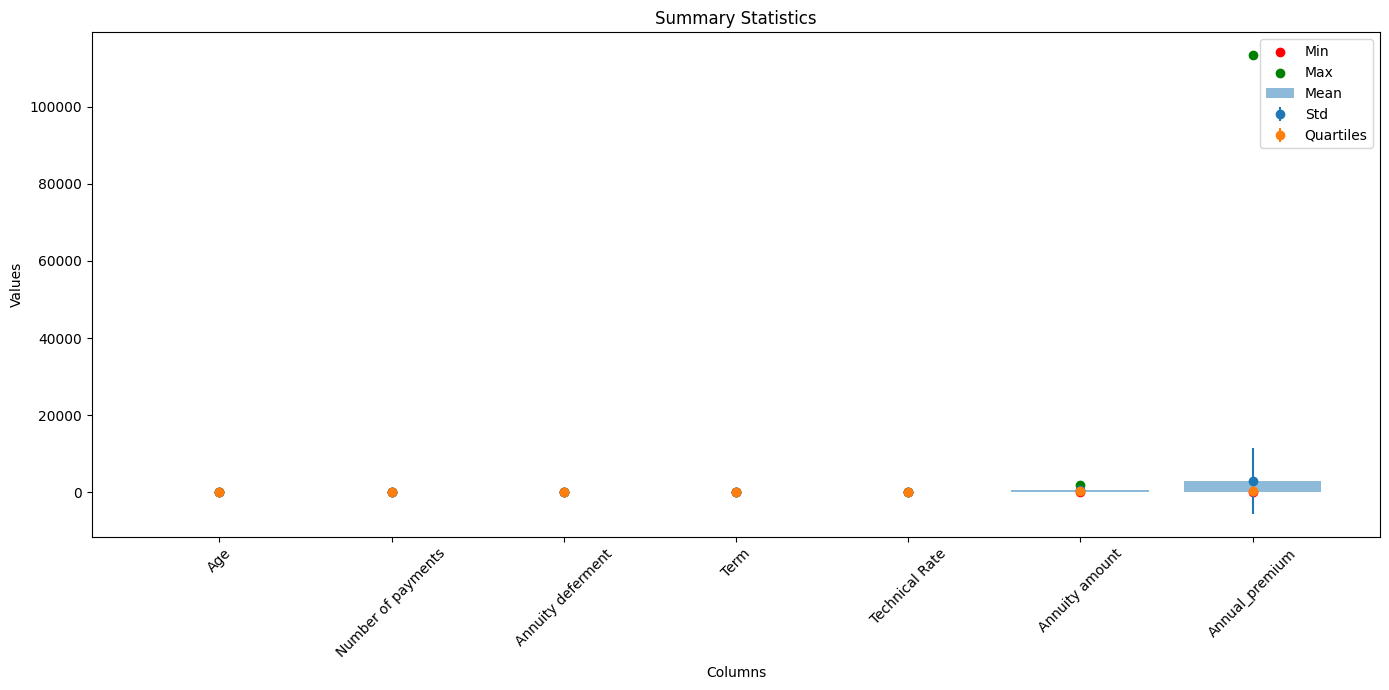

In [159]:

# We print the mean, std, min, max, the 25-50-75% quartiles of each culumn
# Calculate summary statistics
summary_stats = df.describe()

# Extracting summary statistics for plotting
means = summary_stats.loc['mean']
stds = summary_stats.loc['std']
mins = summary_stats.loc['min']
maxs = summary_stats.loc['max']
quartiles = summary_stats.loc[['25%', '50%', '75%']]


print(summary_stats)
# Creating bar plots for summary statistics
plt.figure(figsize=(14,7))

# Mean
plt.bar(means.index, means.values, alpha=0.5, label='Mean')

# Standard Deviation
plt.errorbar(stds.index, means.values, yerr=stds.values, fmt='o', label='Std')

# Min and Max
plt.scatter(mins.index, mins.values, color='red', marker='o', label='Min')
plt.scatter(maxs.index, maxs.values, color='green', marker='o', label='Max')

# Quartiles
plt.errorbar(quartiles.columns, quartiles.loc['50%'], yerr=[quartiles.loc['50%'] - quartiles.loc['25%'], quartiles.loc['75%'] - quartiles.loc['50%']], fmt='o', label='Quartiles')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Summary Statistics')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**<font color='green' face='Time New Roman'>Countplot for categoricals variables**


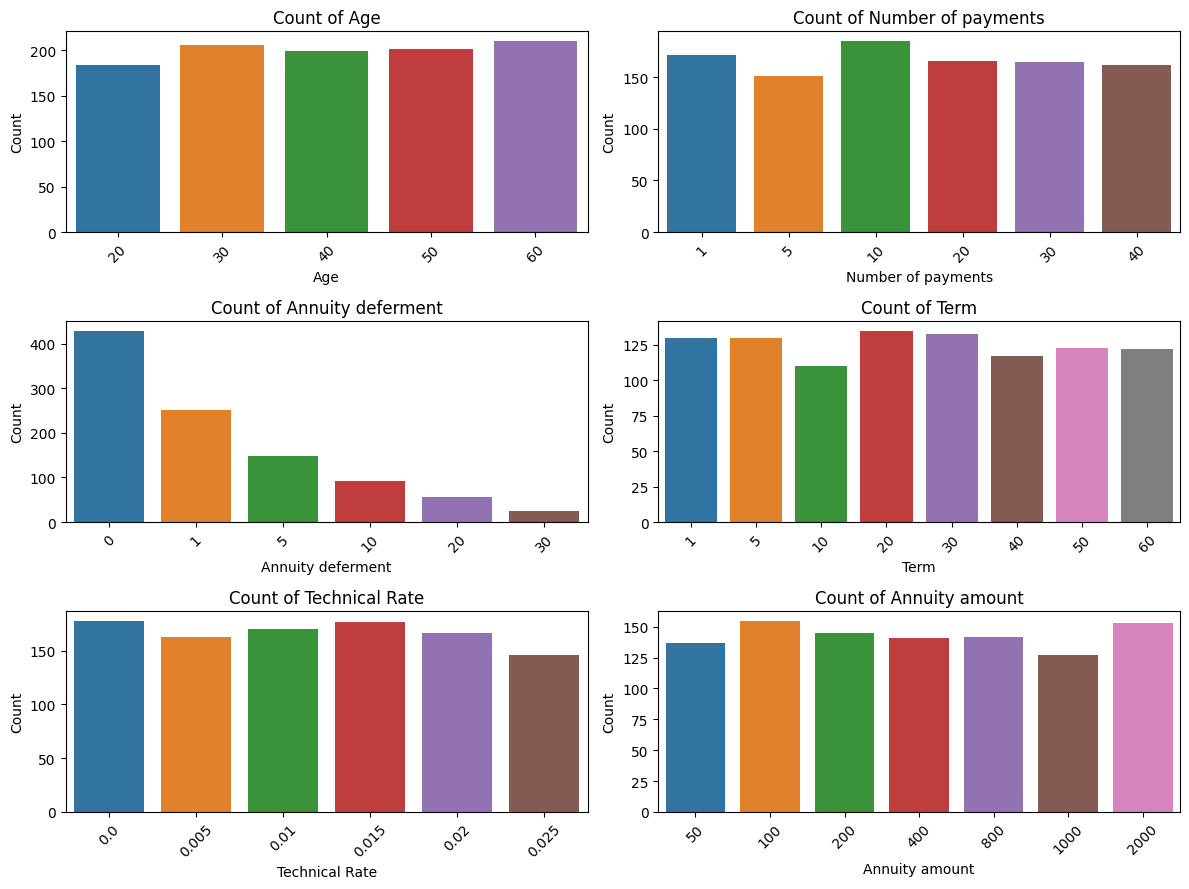

In [160]:
#attributes
numeric_columns = ['Age', 'Number of payments', 'Annuity deferment', 'Term', 'Technical Rate', 'Annuity amount'] # Annual_premium and Single_premiums both take a lot of values !!

# Determining the number of rows and columns based on the number of attributes
num_cols = len(numeric_columns)
num_rows = (num_cols + 1) // 2  # Add 1 to round up to the nearest integer

# Creating a layout of subplots with the correct number of rows and columns
fig, axs = plt.subplots(num_rows, 2, figsize=(12, 3 * num_rows))

# Flattening the axes list for easier iteration
axs = axs.flatten()

for i, param in enumerate(numeric_columns):
    sns.countplot(data=df, x=param, ax=axs[i])
    axs[i].set_title(f'Count of {param}')
    axs[i].set_xlabel(param)
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=45)

# Removing unused axes if there are fewer plots than created axes
for j in range(num_cols, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


**<font color='green' face='Time New Roman'>Correlation matrix between attributes**


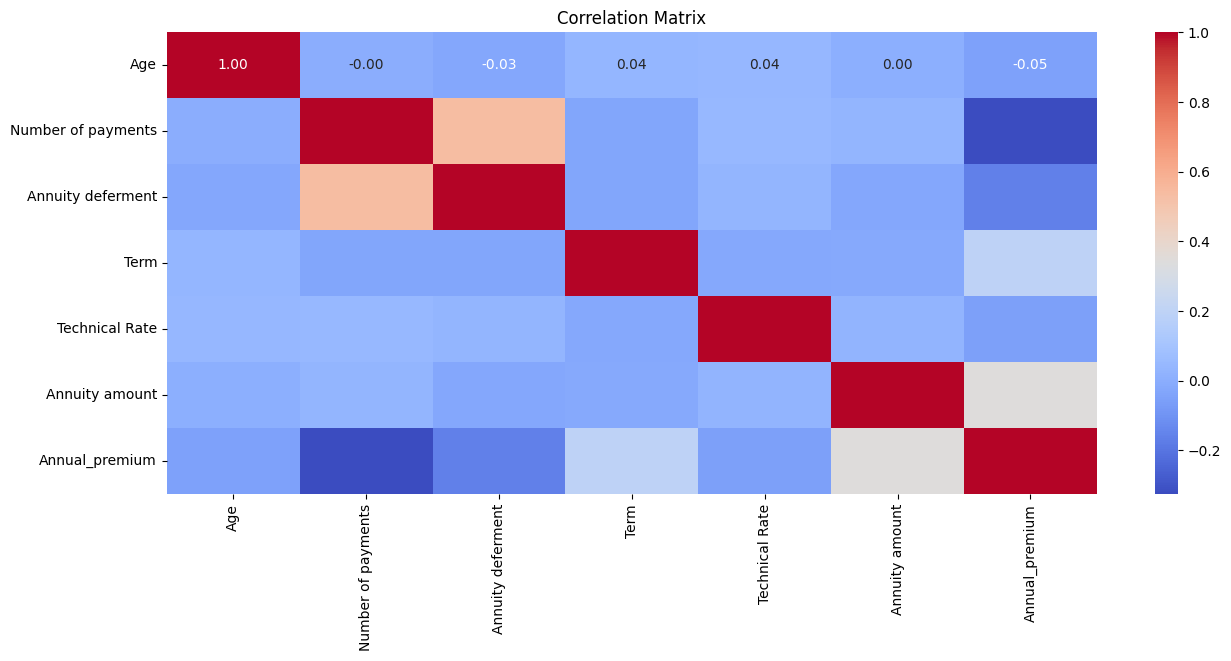

In [162]:
correlation_matrix = df.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


**<font color='green' face='Time New Roman'>Histograms**



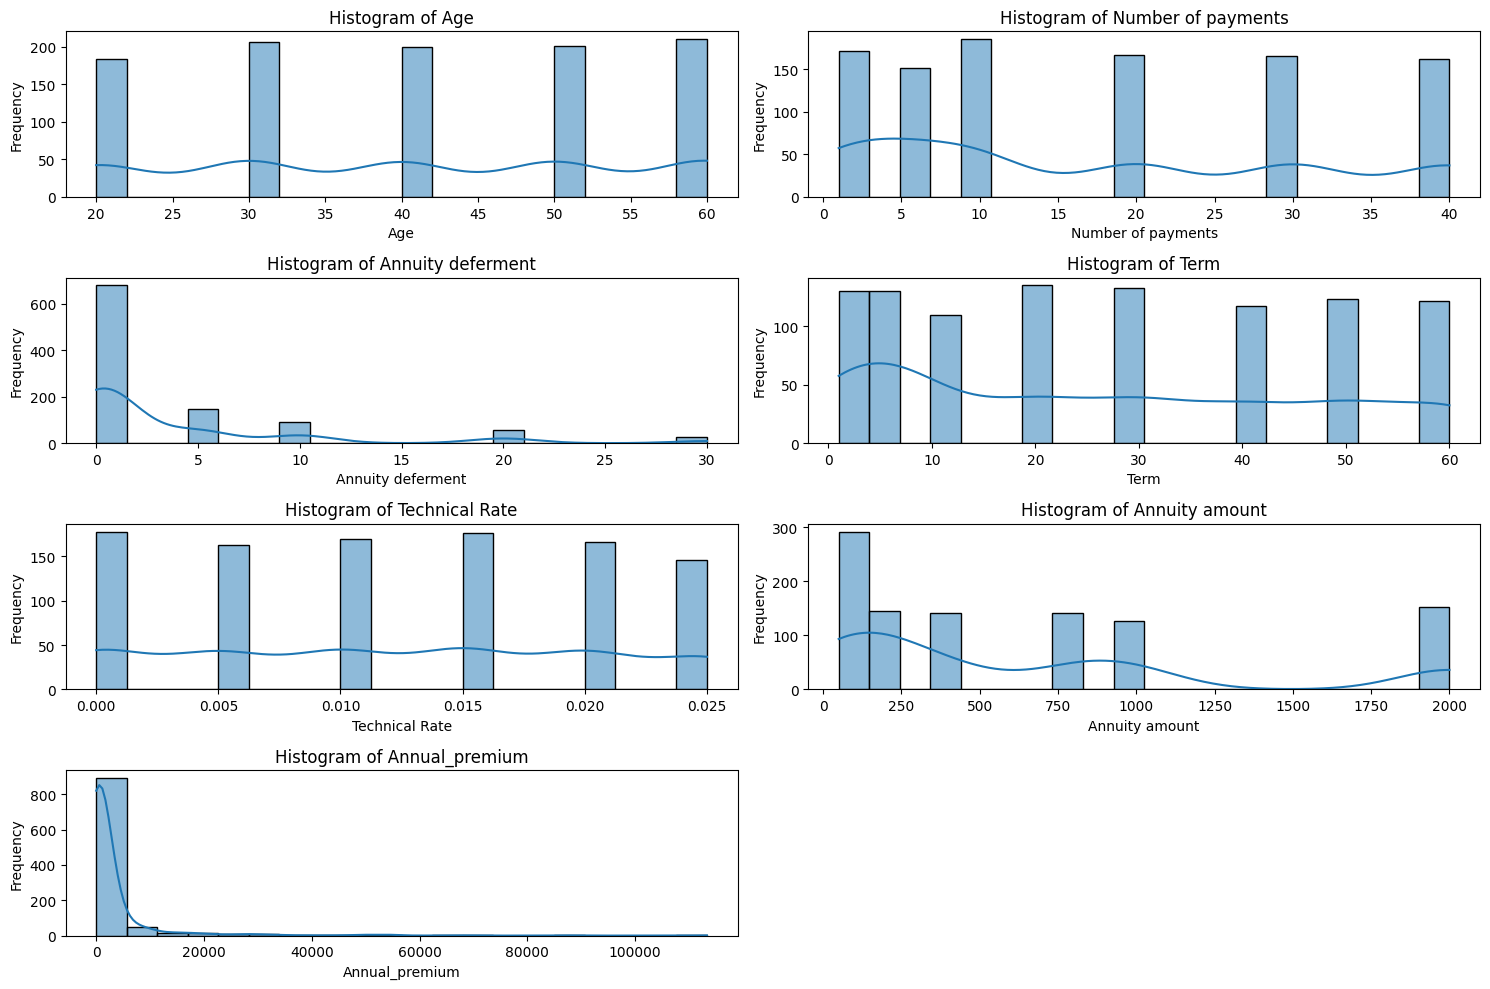

In [163]:

numeric_columns1 = ['Age', 'Number of payments', 'Annuity deferment', 'Term', 'Technical Rate', 'Annuity amount','Annual_premium',]
num_rows = (len(numeric_columns1) // 2) + (len(numeric_columns1) % 2)  # Calculating number of rows for subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 10))  # Creating subplots

for i, column in enumerate(numeric_columns1):
    row = i // 2  # subplot row
    col = i % 2   # subplot column
    sns.histplot(df[column], bins=20, kde=True, ax=axs[row, col])
    axs[row, col].set_title(f'Histogram of {column}')
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Frequency')

if len(numeric_columns1) % 2 != 0:
    fig.delaxes(axs[num_rows - 1, 1])

plt.tight_layout()  # Adjusting layout
plt.show()



**<font color='green' face='Time New Roman'>Pairplot**


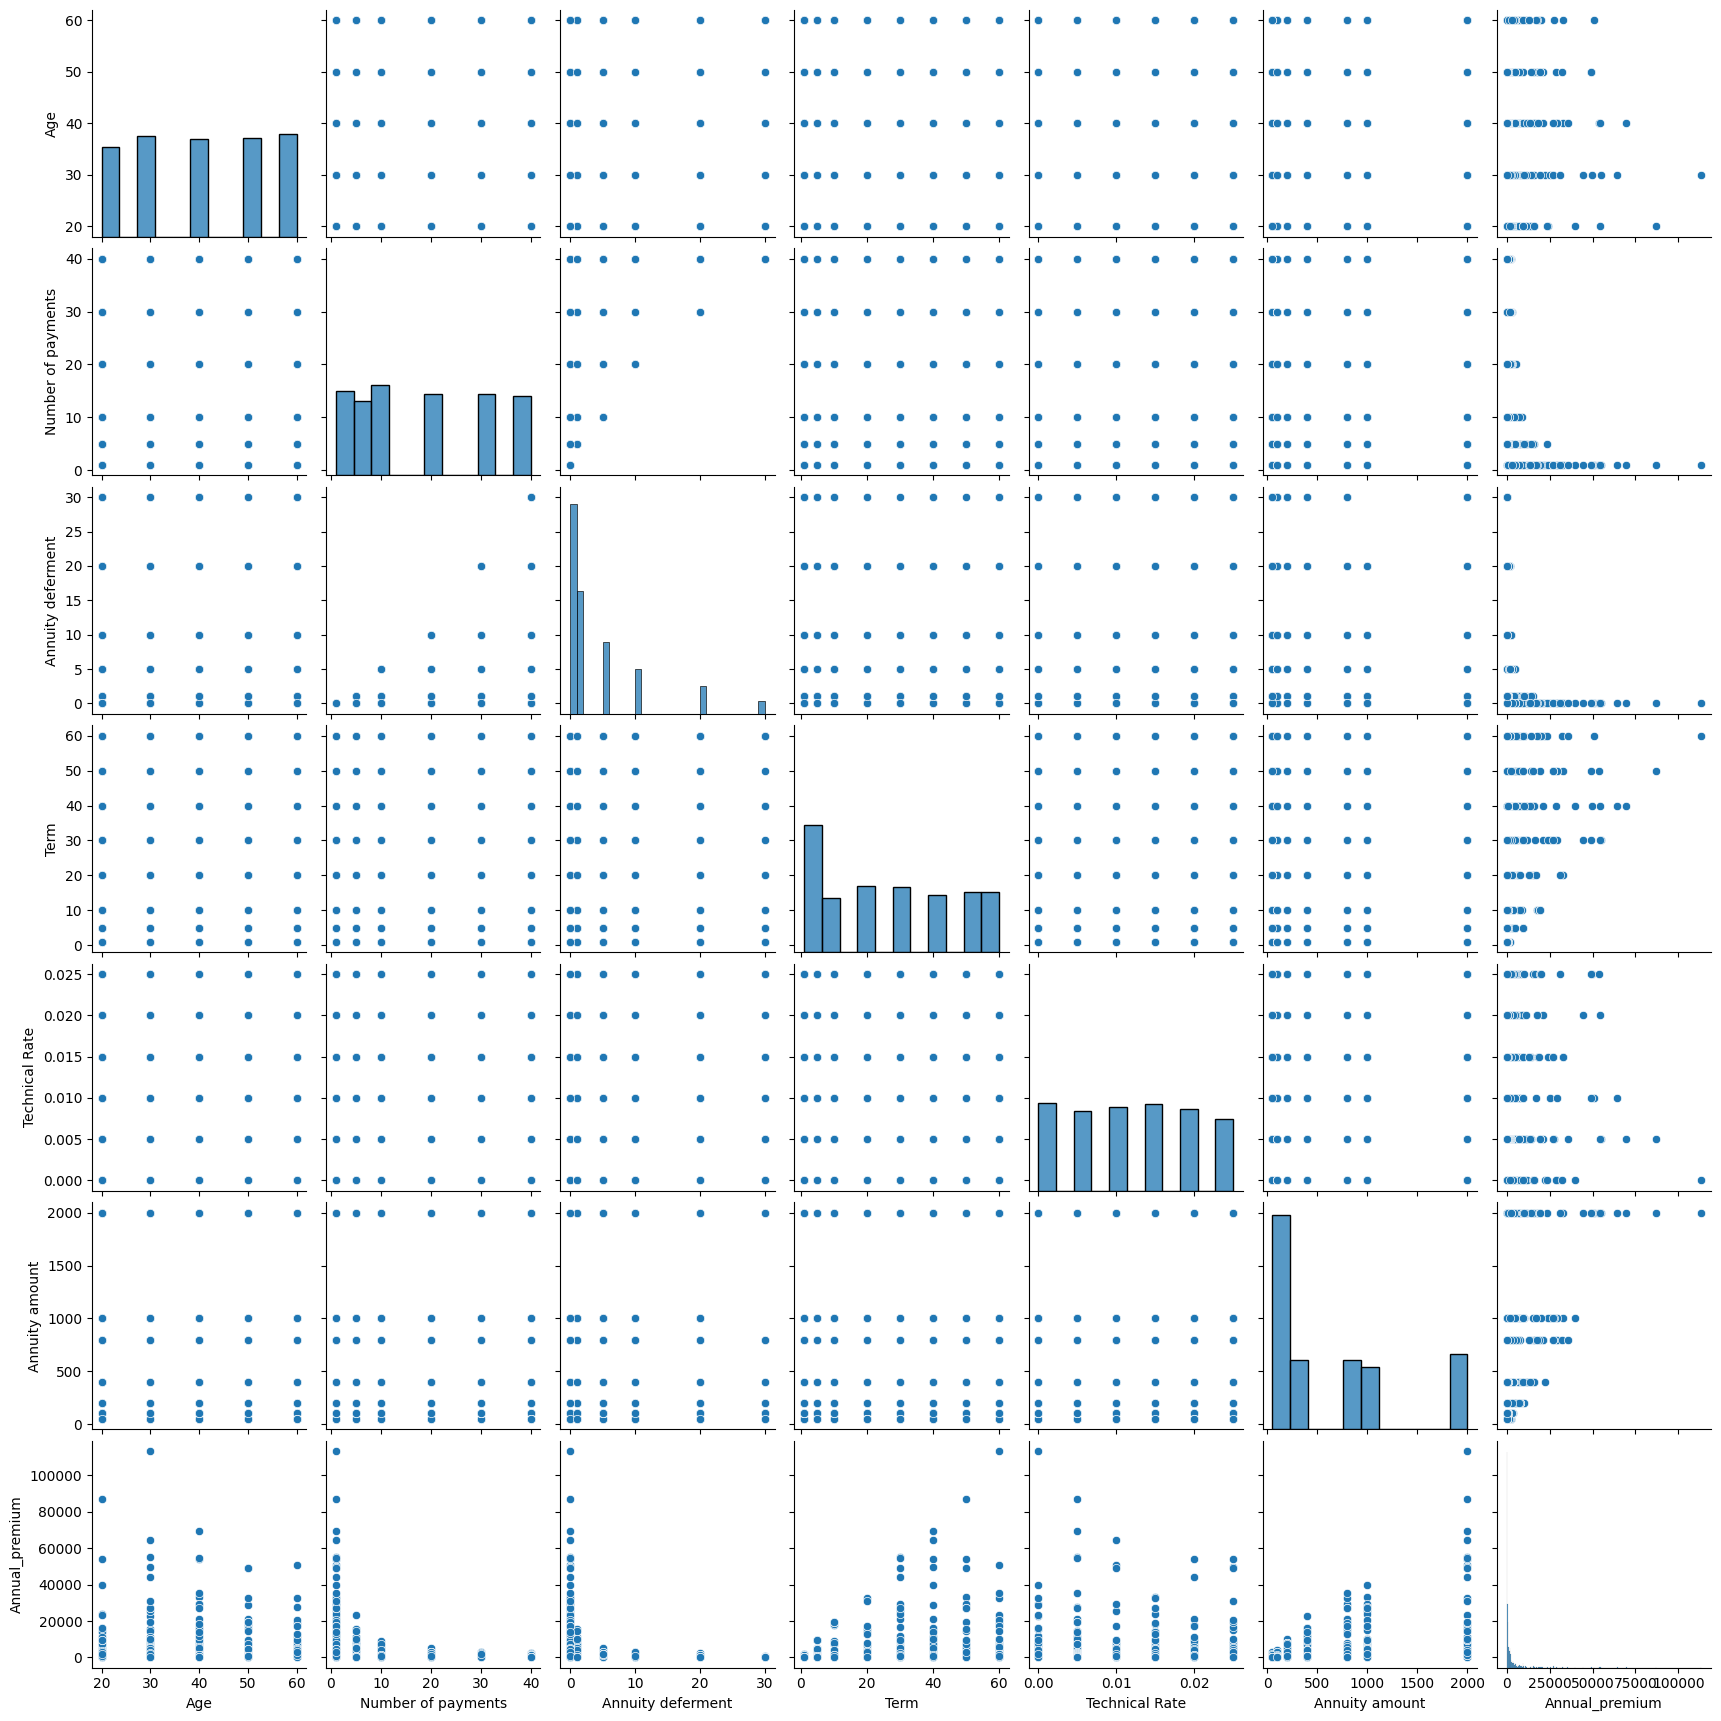

In [164]:
sns.pairplot(df)
plt.show()


**<font color='green' face='Time New Roman'>Boxplots**


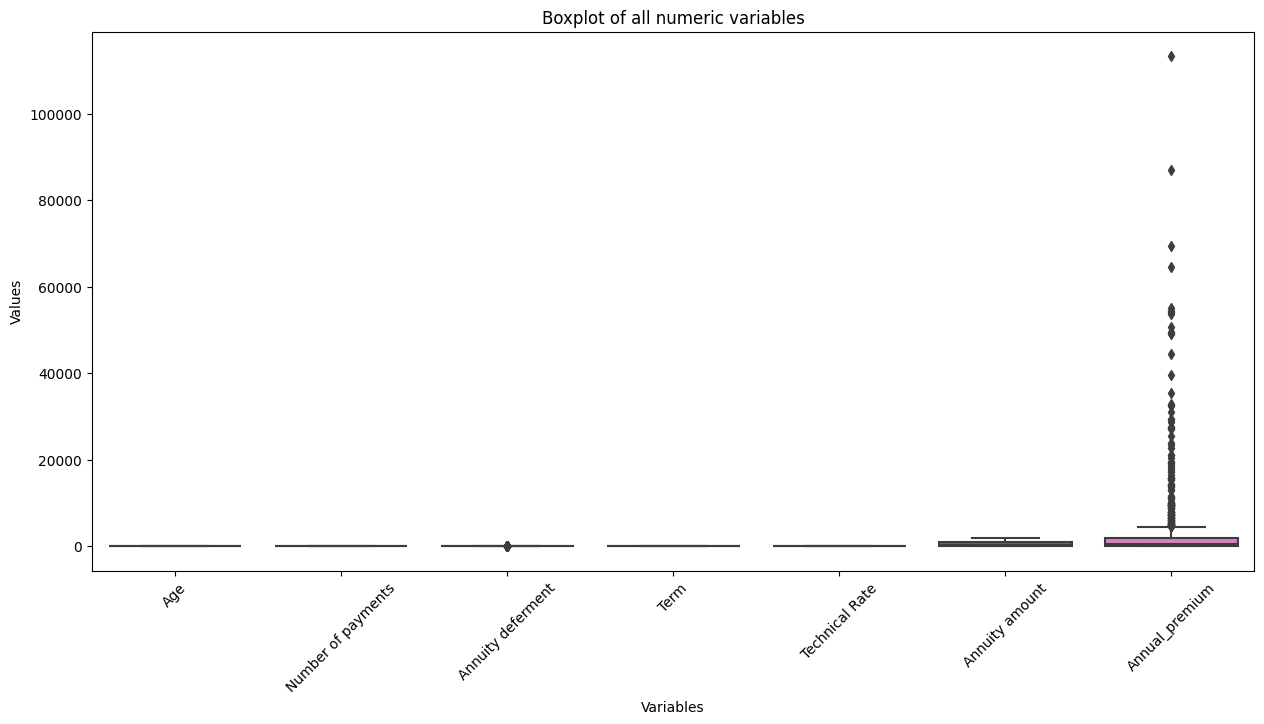

In [168]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df)
plt.title('Boxplot of all numeric variables')
plt.xlabel('Variables') 
plt.ylabel('Values') 
plt.xticks(rotation=45)
plt.show()

**<font color='green' face='Time New Roman'>Boxplots of Annual_prmium by Term**


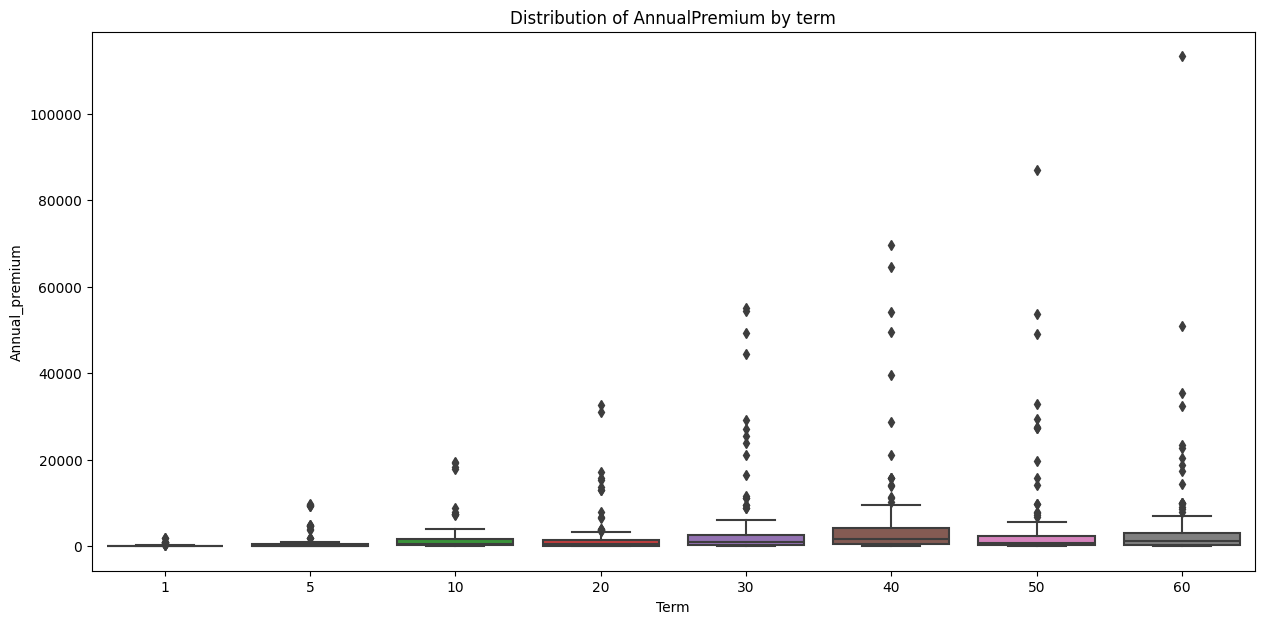

In [167]:
plt.figure(figsize=(15, 7))
sns.boxplot(x='Term', y='Annual_premium', data=df)
plt.title("Distribution of AnnualPremium by term")
plt.xlabel("Term")
plt.ylabel("Annual_premium")
plt.show()


**<font color='green' face='Time New Roman'>Scatterplots for pairs of attributes**


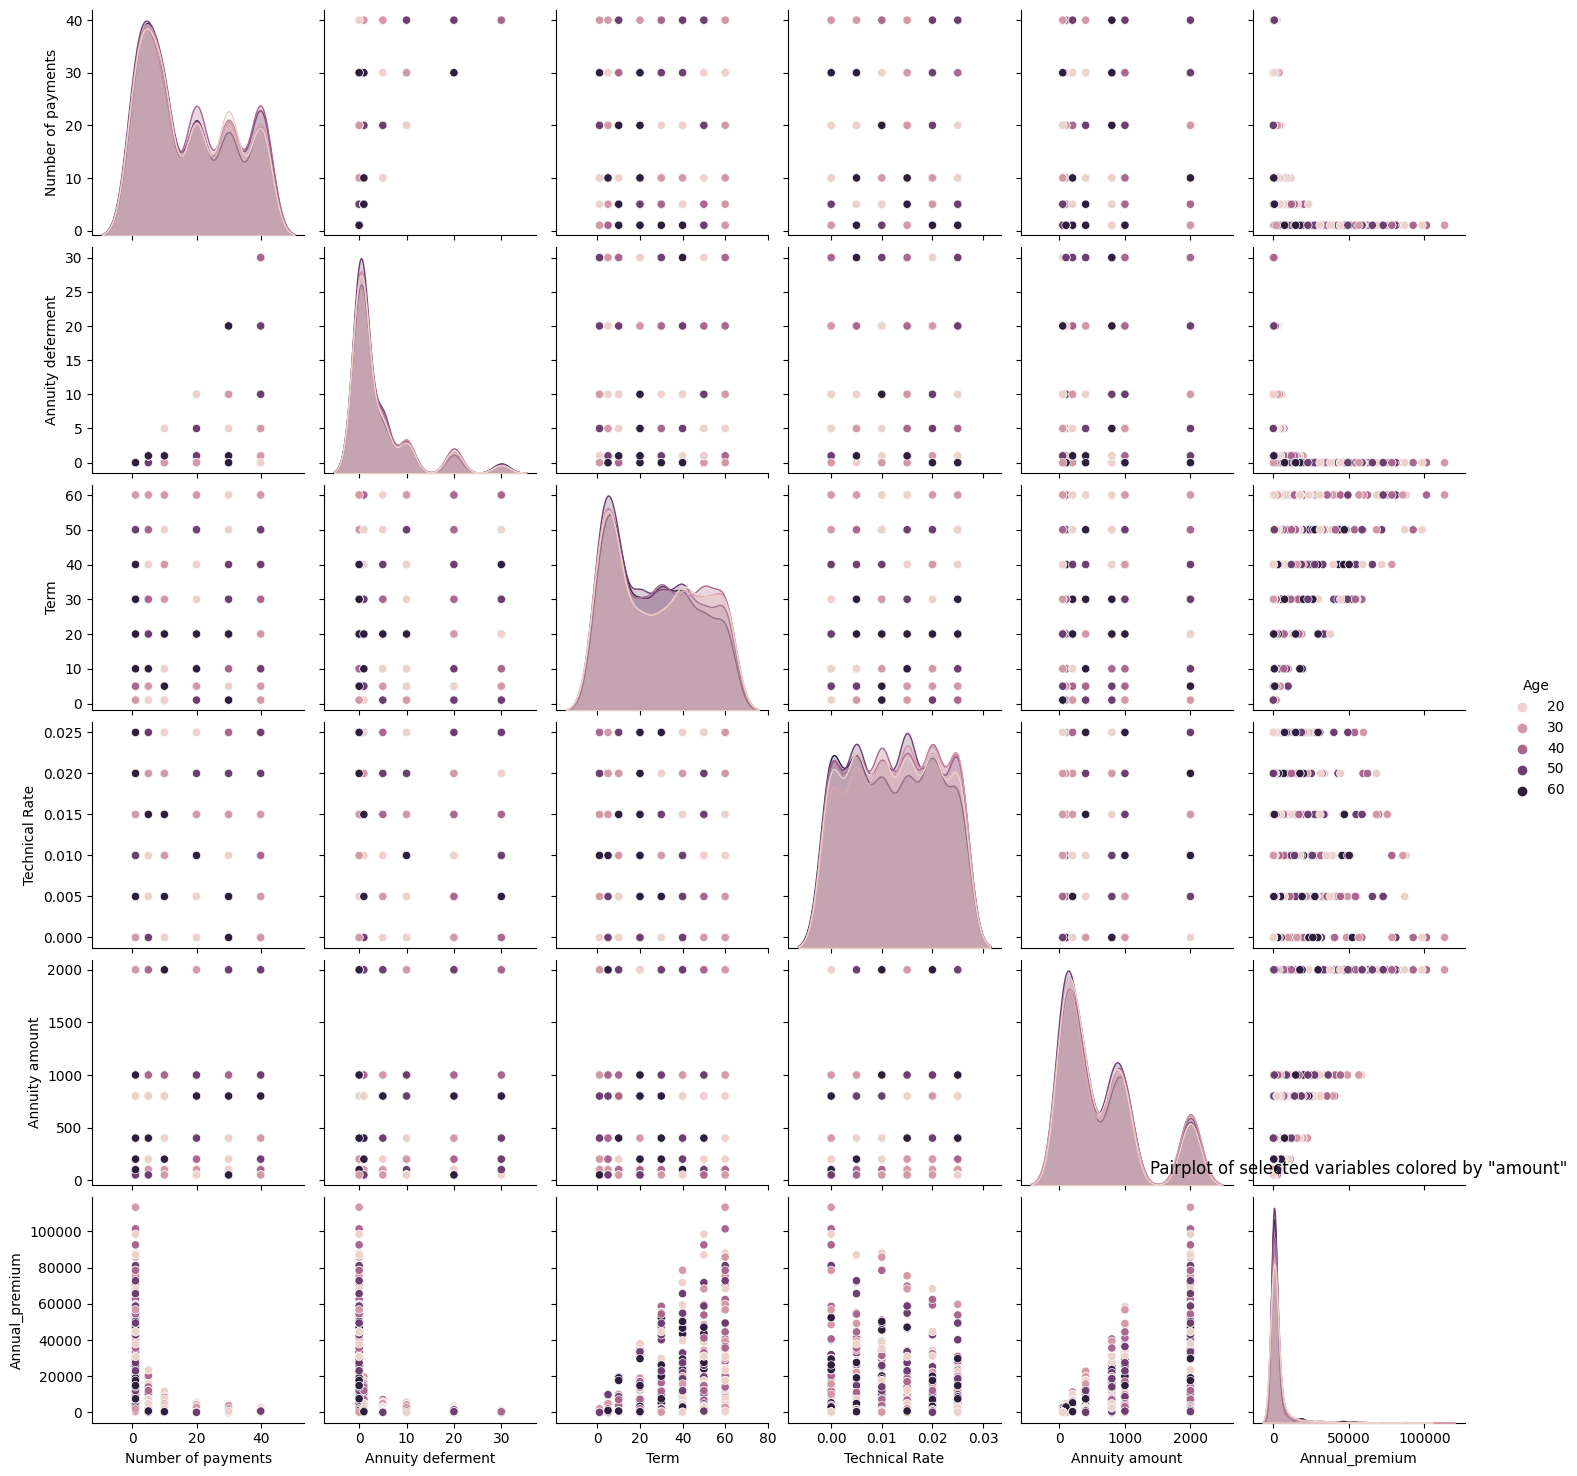

In [105]:
sns.pairplot(df, vars=[ 'Number of payments', 'Annuity deferment', 'Term', 'Technical Rate', 'Annuity amount','Annual_premium',], hue='Age')
plt.title('Pairplot of selected variables colored by "amount"')
plt.show()

**<font color='green' face='Time New Roman'>Scatter plot between Age and AnnualPremium**

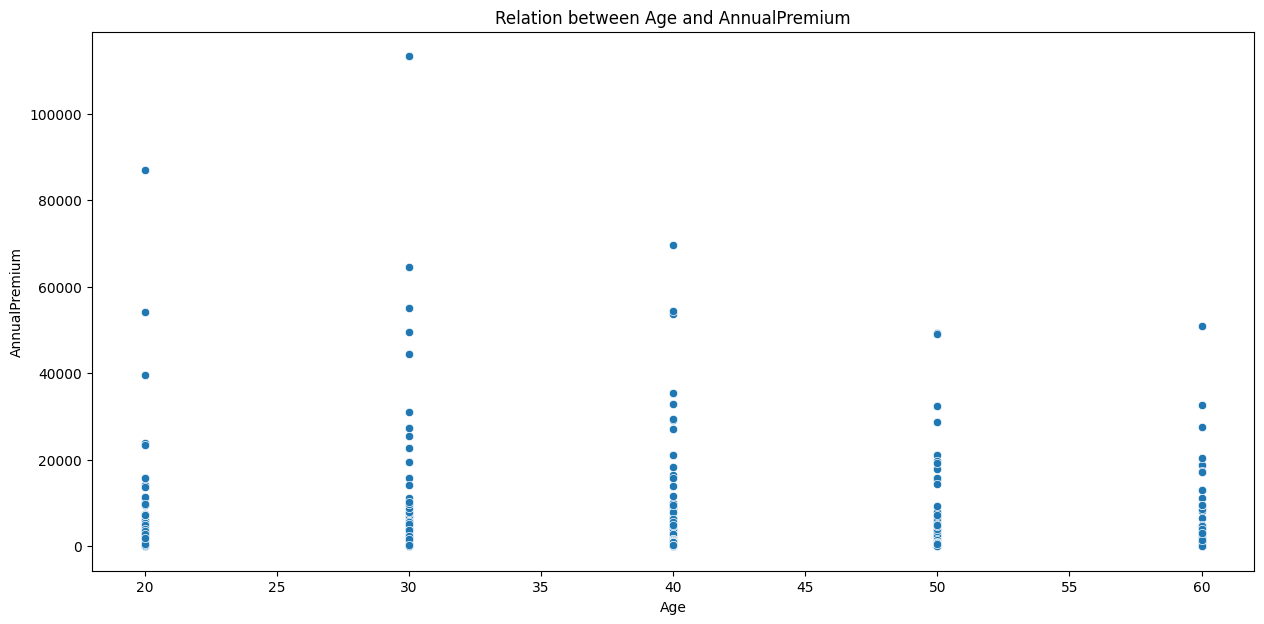

In [169]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x='Age', y='Annual_premium', data=df)
plt.title("Relation between Age and AnnualPremium")
plt.xlabel("Age")
plt.ylabel("AnnualPremium")
plt.show()

 ## <font color='brown' face='Time New Roman'>3. Machine Learning models study</font> 

**<font color='green' face='Time New Roman'>Linear Regression**

Predicted Annual Premium for new data: [4553.271315]
The Actuarial value of Annual Premium for new data: 1221.1826420658028
lr.coef_: [-3.18848825e+01 -2.13955942e+02  4.61213338e+01  8.15253590e+01
 -4.03996058e+04  4.62433242e+00]
lr.intercept_: 3066.7636954192462
Mean Squared Error: 109518349.58931087
Mean Absolute Error: 4781.268183246632
R-squared Score: 0.24933297938220556


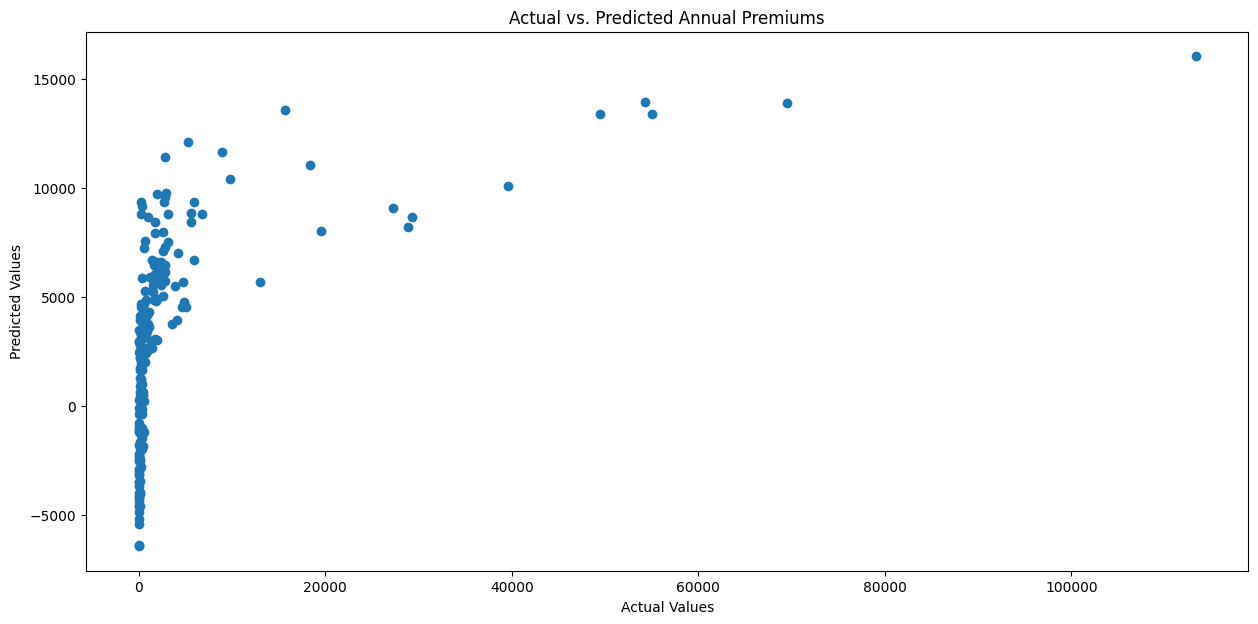

In [198]:
# Splitting the dataset into training and testing sets
X=df[['Age', 'Number of payments', 'Annuity deferment', 'Term', 'Technical Rate', 'Annuity amount']]
y=df['Annual_premium']
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Initializing the Linear Regression model
model = LinearRegression()

# Fiting the model on the training data
lr=model.fit(X,y)

# Predicting on the test set
y_pred = model.predict(X_test)
# Evaluating model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# To make predictions on new data with model.predict()
new_data_Actuarial = anuualPremium(25,20,15,0.02,1000,1)
new_data_Ml = pd.DataFrame({'Age' : [25], 'Number of payments':[15], 'Annuity deferment':[1], 'Term':[20], 'Technical Rate':[0.02], 'Annuity amount':[1000]})
predicted_annual_premium = model.predict(new_data_Ml)
print("Predicted Annual Premium for new data:", predicted_annual_premium)
print("The Actuarial value of Annual Premium for new data:", new_data_Actuarial)

print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

# Visualizing actual vs. predicted values
plt.figure(figsize=(15, 7))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Annual Premiums')
plt.show()

**<font color='green' face='Time New Roman'>Lasso Regression**

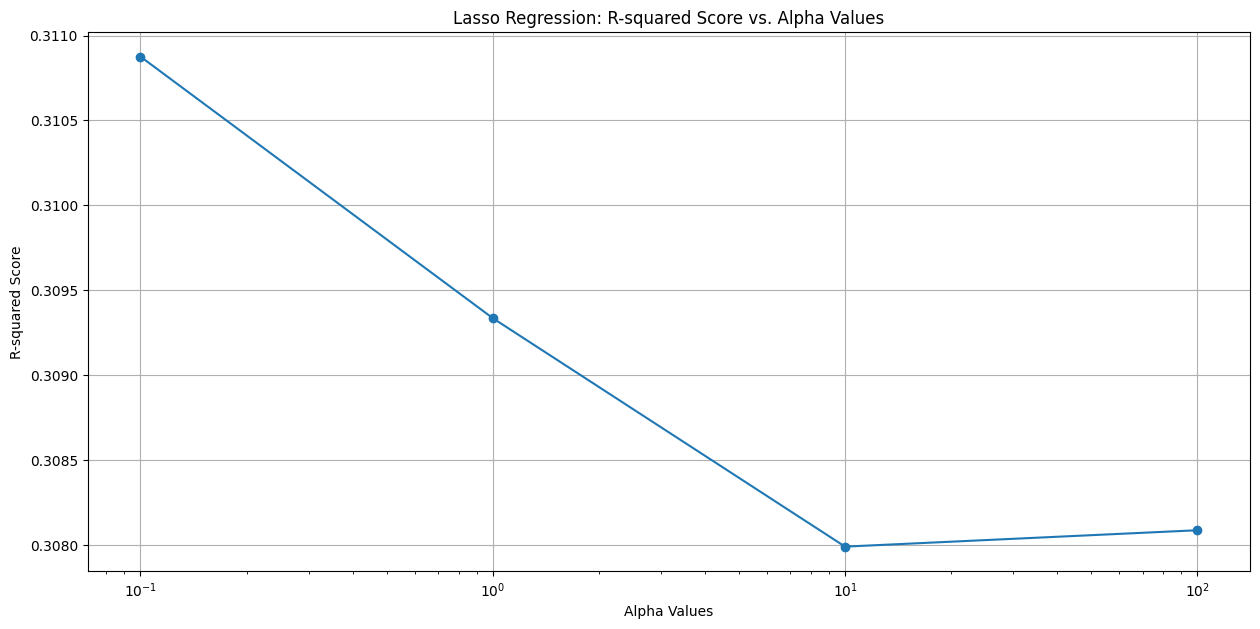

Best alpha value based on R-squared score: 0.1
R-squared score for Lasso Regression on test set with best alpha: 0.2286148195365132
Predicted 'Annual_premium' for new_data_Ml using Lasso Regression: 4090.405490627148
The Actuarial value of Annual Premium for new data: 1221.1826420658028
Best value corresponding to the best alpha: -3530.319620660358


In [199]:
# Splitting the data into training (70%), validation (15%), and testing (15%) sets
X = df[['Age', 'Number of payments', 'Annuity deferment', 'Term', 'Technical Rate', 'Annuity amount']]
y = df['Annual_premium']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

# Defining a range of alpha values to try
alpha_values = [0.1, 1, 10, 100]  # Add more alphas as needed

# Initializing lists to store alpha values and their corresponding R-squared scores
alphas = []
r2_scores = []

# Iterating over different alpha values
for alpha in alpha_values:
    # Initializing Lasso Regression model with the current alpha
    lasso_model = Lasso(alpha=alpha)
    
    # Fiting the Lasso model on the training data
    lasso_model.fit(X_train, y_train)
    
    # Predicting on the validation set
    y_pred_val = lasso_model.predict(X_val)
    
    # Calculating R-squared score
    r2 = r2_score(y_val, y_pred_val)
    
    # Appending alpha and R-squared score to the lists
    alphas.append(alpha)
    r2_scores.append(r2)

# Plotting R-squared scores vs. alpha values
plt.figure(figsize=(15, 7))
plt.plot(alphas, r2_scores, marker='o')
plt.xlabel('Alpha Values')
plt.ylabel('R-squared Score')
plt.title('Lasso Regression: R-squared Score vs. Alpha Values')
plt.xscale('log')  # Using a logarithmic scale for alpha values for better visualization
plt.grid(True)
plt.show()

# Getting the index of the maximum R-squared score
best_alpha_index = np.argmax(r2_scores)
best_alpha = alphas[best_alpha_index]

print(f"Best alpha value based on R-squared score: {best_alpha}")

# Training Lasso Regression with the best alpha on the combined training and validation sets
lasso_best_model = Lasso(alpha=best_alpha)
lasso_best_model.fit(X_train_val, y_train_val)

# Evaluating the best Lasso model on the test set
y_pred_test_lasso = lasso_best_model.predict(X_test)
r2_test_lasso = r2_score(y_test, y_pred_test_lasso)

print(f"R-squared score for Lasso Regression on test set with best alpha: {r2_test_lasso}")


# Printing the predicted value
predicted_annual_premium_lasso = lasso_best_model.predict(new_data_Ml)

print(f"Predicted 'Annual_premium' for new_data_Ml using Lasso Regression: {predicted_annual_premium_lasso[0]}")
print("The Actuarial value of Annual Premium for new data:", new_data_Actuarial)


# Calculating and print the best value corresponding to the best alpha
coef = lasso_best_model.coef_
intercept = lasso_best_model.intercept_

best_value = np.dot(coef, X_test.iloc[0]) + intercept
print(f"Best value corresponding to the best alpha: {best_value}")

**<font color='green' face='Time New Roman'>Polynomial Regression**

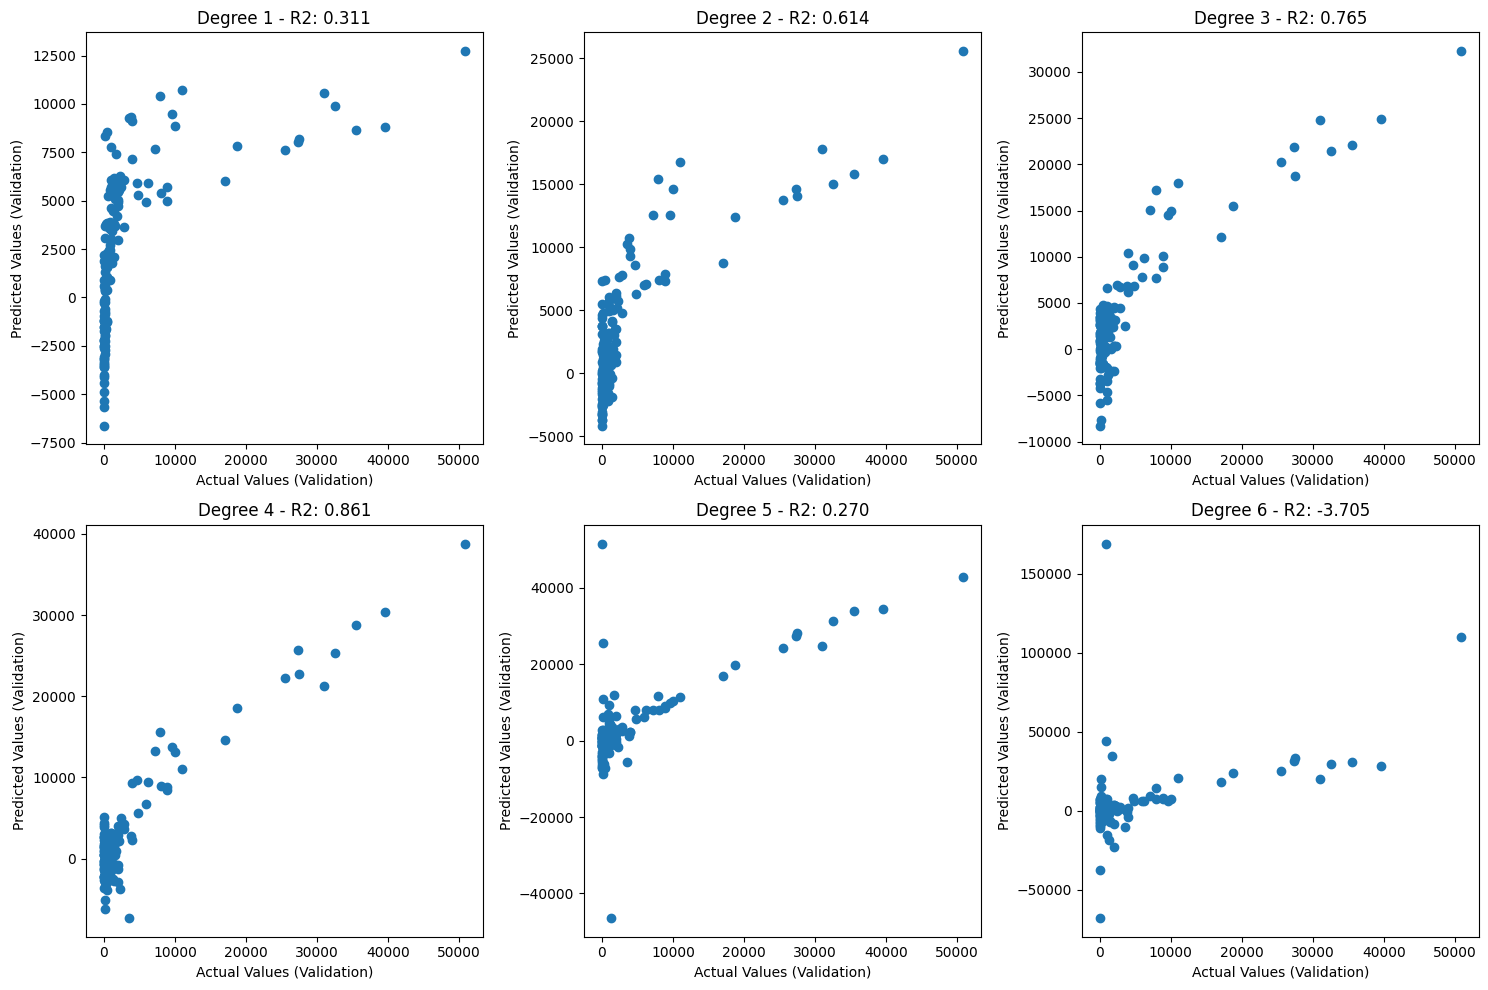

R-squared score for Polynomial Regression (Degree 1) on test set: 0.229
R-squared score for Polynomial Regression (Degree 2) on test set: 0.530
R-squared score for Polynomial Regression (Degree 3) on test set: 0.729
R-squared score for Polynomial Regression (Degree 4) on test set: 0.816
R-squared score for Polynomial Regression (Degree 5) on test set: 0.777
R-squared score for Polynomial Regression (Degree 6) on test set: -15.058

Best degree found: 4
R-squared score for Polynomial Regression (Best Degree) on test set: 0.816
Predicted 'Annual_premium' for new_data_Ml using Polynomial Regression: -1456.1349299675567
The Actuarial value of Annual Premium for new data: 1221.1826420658028


In [200]:
# Splitting the data into training (70%), validation (15%) and testing (15%) sets
X = df[['Age', 'Number of payments', 'Annuity deferment', 'Term', 'Technical Rate', 'Annuity amount']]
y = df['Annual_premium']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

# Degrees of polynomial regression
degrees = [1, 2, 3, 4, 5,6]  
best_degree = None
best_r2 = -float('inf')

# Initializing subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 plots

for idx, degree in enumerate(degrees):
    # Creating polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_val_poly = poly_features.transform(X_val)

    # Initializing and fit the polynomial regression model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # Predicting on the validation set
    y_pred_val = poly_model.predict(X_val_poly)

    # Calculating R-squared score
    r2_val = r2_score(y_val, y_pred_val)

    # Ploting actual vs. predicted values for validation set in the subplots
    row = idx // 3  # row index for subplots
    col = idx % 3   # column index for subplots

    axs[row, col].scatter(y_val, y_pred_val)
    axs[row, col].set_xlabel('Actual Values (Validation)')
    axs[row, col].set_ylabel('Predicted Values (Validation)')
    axs[row, col].set_title(f'Degree {degree} - R2: {r2_val:.3f}')

plt.tight_layout()  # Adjusting subplots to prevent overlap
plt.show()

for degree in degrees:
    # Creating polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_val)
    X_test_poly = poly_features.transform(X_test)

    # Initializing and fit the polynomial regression model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train_val)

    # Predicting on the test set
    y_pred_test = poly_model.predict(X_test_poly)

    # Calculating R-squared score on the test set
    r2_test = r2_score(y_test, y_pred_test)

    print(f"R-squared score for Polynomial Regression (Degree {degree}) on test set: {r2_test:.3f}")

    # Checking if this degree has a better R-squared score
    if r2_test > best_r2:
        best_r2 = r2_test
        best_degree = degree

print(f"\nBest degree found: {best_degree}")
print(f"R-squared score for Polynomial Regression (Best Degree) on test set: {best_r2:.3f}")

# Creating polynomial features for the best degree
poly_features = PolynomialFeatures(degree=best_degree)
X_train_val_poly = poly_features.fit_transform(X_train_val)
X_test_poly = poly_features.transform(X_test)
new_data_Ml_poly = poly_features.transform(new_data_Ml)

# Initializing and fit the polynomial regression model with the best degree on the combined training and validation sets
poly_model = LinearRegression()
poly_model.fit(X_train_val_poly, y_train_val)

# Predicting the 'Annual_premium' for new_data_Ml using the trained Polynomial Regression model
predicted_annual_premium_poly = poly_model.predict(new_data_Ml_poly)

# Printing the predicted value
print(f"Predicted 'Annual_premium' for new_data_Ml using Polynomial Regression: {predicted_annual_premium_poly[0]}")
print("The Actuarial value of Annual Premium for new data:", new_data_Actuarial)


**<font color='green' face='Time New Roman'>Random Forest**

Random Forest Training Score : 0.9934515961413127
Random Forest Test Score: 0.926


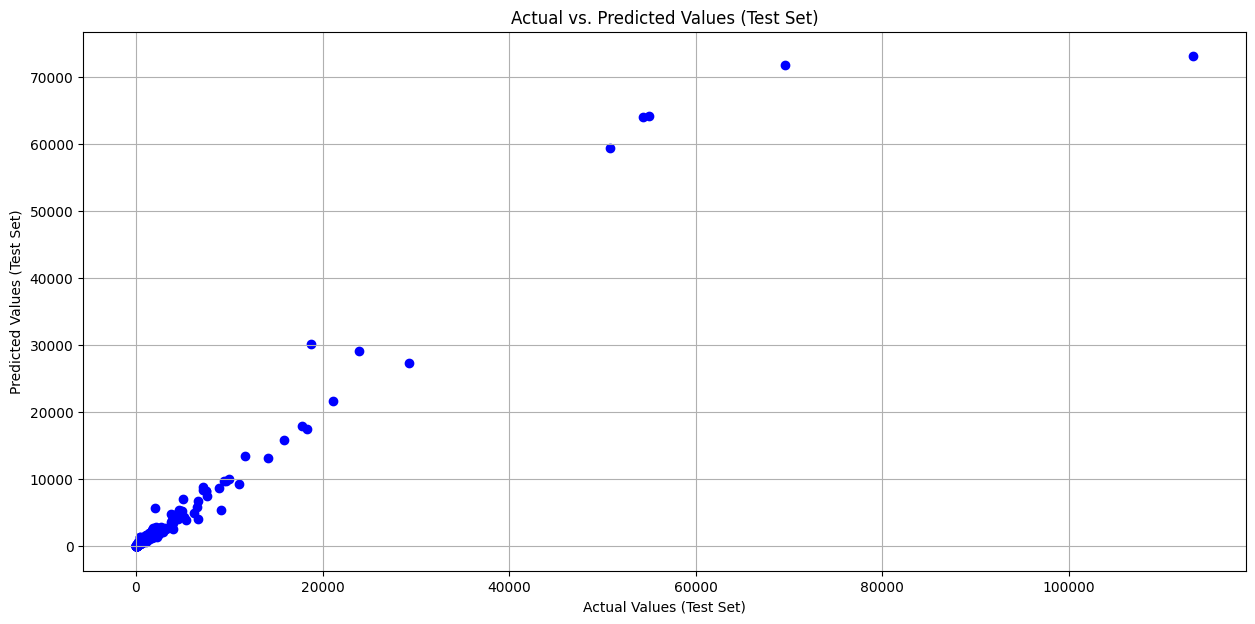

Predicted 'Annual_premium' for new_data_Ml using Random Forest: 2725.7155474604638
The Actuarial value of Annual Premium for new data: 1221.1826420658028


In [208]:
# Splitting the data into features (X) and target (y)
X = df[['Age', 'Number of payments', 'Annuity deferment', 'Term', 'Technical Rate', 'Annuity amount']]
y = df['Annual_premium']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# Creating and training the Random Forest model
rf = RandomForestRegressor(n_estimators=1000, max_depth=15, random_state=5)
rf.fit(X_train, y_train)

# Evaluating the model on the test set
y_pred_test = rf.predict(X_test)
test_score = r2_score(y_test, y_pred_test)
forest_train_score = rf.score(X_train, y_train)

print("Random Forest Training Score :", forest_train_score)
print(f"Random Forest Test Score: {test_score:.3f}")

# Plotting actual vs predicted values for the test set
plt.figure(figsize=(15, 7))
plt.scatter(y_test, y_pred_test, color='blue')
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Predicted Values (Test Set)')
plt.title('Actual vs. Predicted Values (Test Set)')
plt.grid(True)
plt.show()

# Predicting the 'Annual_premium' for new_data_Ml
predicted_annual_premium = rf.predict(new_data_Ml)
print(f"Predicted 'Annual_premium' for new_data_Ml using Random Forest: {predicted_annual_premium[0]}")
print("The Actuarial value of Annual Premium for new data:", new_data_Actuarial)

**<font color='green' face='Time New Roman'>Decision Tree**

Decision Tree Regression Training Score: 0.999
Decision Tree Regression Test Score: 0.954
Decision Tree Regression Validation Score: 0.975


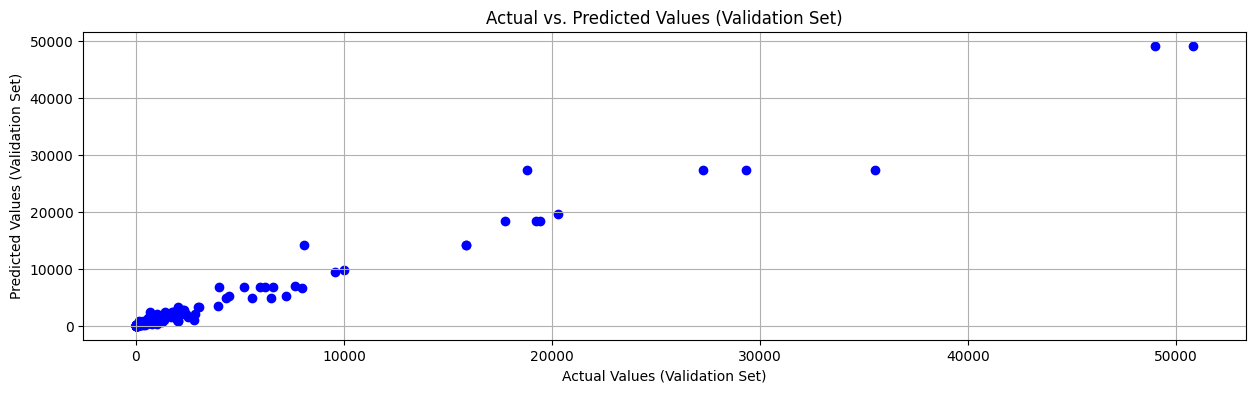

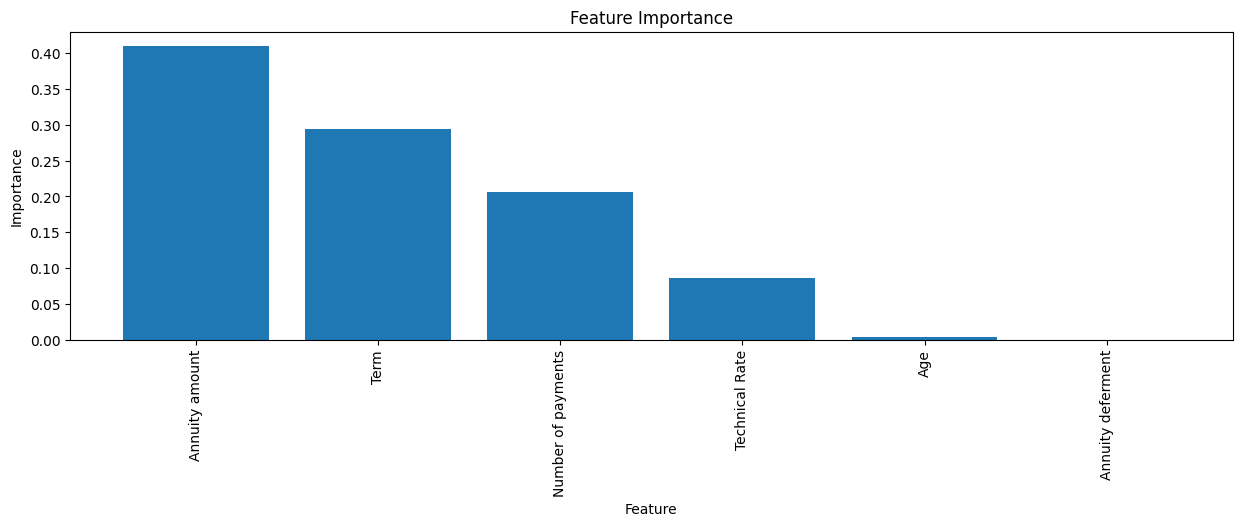

Predicted 'Annual_premium' for new_data_Ml using Decision Tree: 1831.5426520236417
The Actuarial value of Annual Premium for new data: 1221.1826420658028


In [218]:
# Splitting the data into training, validation, and testing sets
X = df[['Age', 'Number of payments', 'Annuity deferment', 'Term', 'Technical Rate', 'Annuity amount']]
y = df['Annual_premium']

# Splitting the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=70)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=70)

# Creating and fitting a Decision Tree regressor
tree_reg = DecisionTreeRegressor(max_depth=7)
tree_reg.fit(X_train, y_train)

# Evaluating the model
train_score = tree_reg.score(X_train, y_train)
test_score = tree_reg.score(X_test, y_test)
valid_score = tree_reg.score(X_val, y_val)

print("Decision Tree Regression Training Score: {:.3f}".format(train_score))
print("Decision Tree Regression Test Score: {:.3f}".format(test_score))
print("Decision Tree Regression Validation Score: {:.3f}".format(valid_score))

# Plotting actual vs predicted values for the validation set
y_pred_val = tree_reg.predict(X_val)

plt.figure(figsize=(15, 4))
plt.scatter(y_val, y_pred_val, color='blue')
plt.xlabel('Actual Values (Validation Set)')
plt.ylabel('Predicted Values (Validation Set)')
plt.title('Actual vs. Predicted Values (Validation Set)')
plt.grid(True)
plt.show()

# Feature importance plot
feature_importance = tree_reg.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]

plt.figure(figsize=(15, 4))
plt.bar(range(X.shape[1]), feature_importance[sorted_idx], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# Predicting the 'Annual_premium' for new_data_Ml
predicted_annual_premium = tree_reg.predict(new_data_Ml)
print(f"Predicted 'Annual_premium' for new_data_Ml using Decision Tree: {predicted_annual_premium[0]}")
print("The Actuarial value of Annual Premium for new data:", new_data_Actuarial)